In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import warnings
from lightgbm import LGBMClassifier
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_validate
import umap
warnings.filterwarnings('ignore')
%matplotlib inline

## Считывание датасета и просмотр статистик

##### Набор данных содержат транзакции, совершенные европейскими держателями кредитных карт в сентябре 2013 года.

In [2]:
df = pd.read_csv('creditcardfraud.zip', compression='zip')

In [3]:
# Датасет содержит анонимизированные признаки
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [4]:
# Все признаки числовые, более 280тыс объектов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
# Пропусков нет
df.isnull().sum().sort_values(ascending=False)

Class     0
V14       0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V15       0
Amount    0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Time      0
dtype: int64

In [6]:
# Теперь посмотрим на основные статистики признаков,
# на некоторых признаках среднее значени сильно отличается от медины, что может свидетельствовоать о выбросах, например v5, v7, Amount 
df.drop(['Class'], axis=1).describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


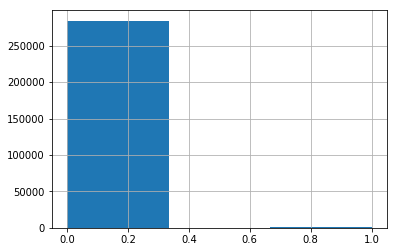

In [7]:
# Целевая переменная очень сильно несбалансирована
df.Class.hist(bins=3)
plt.show()

In [8]:
# Аномальных данных 0,17%, 
# примем эту долю аномалий как экспертную оценку 
ratio = (df.groupby('Class').size() / df['Class'].count())[1] # экспертная оценка
df.groupby('Class').size() / df['Class'].count() * 100

Class
0    99.827251
1     0.172749
dtype: float64

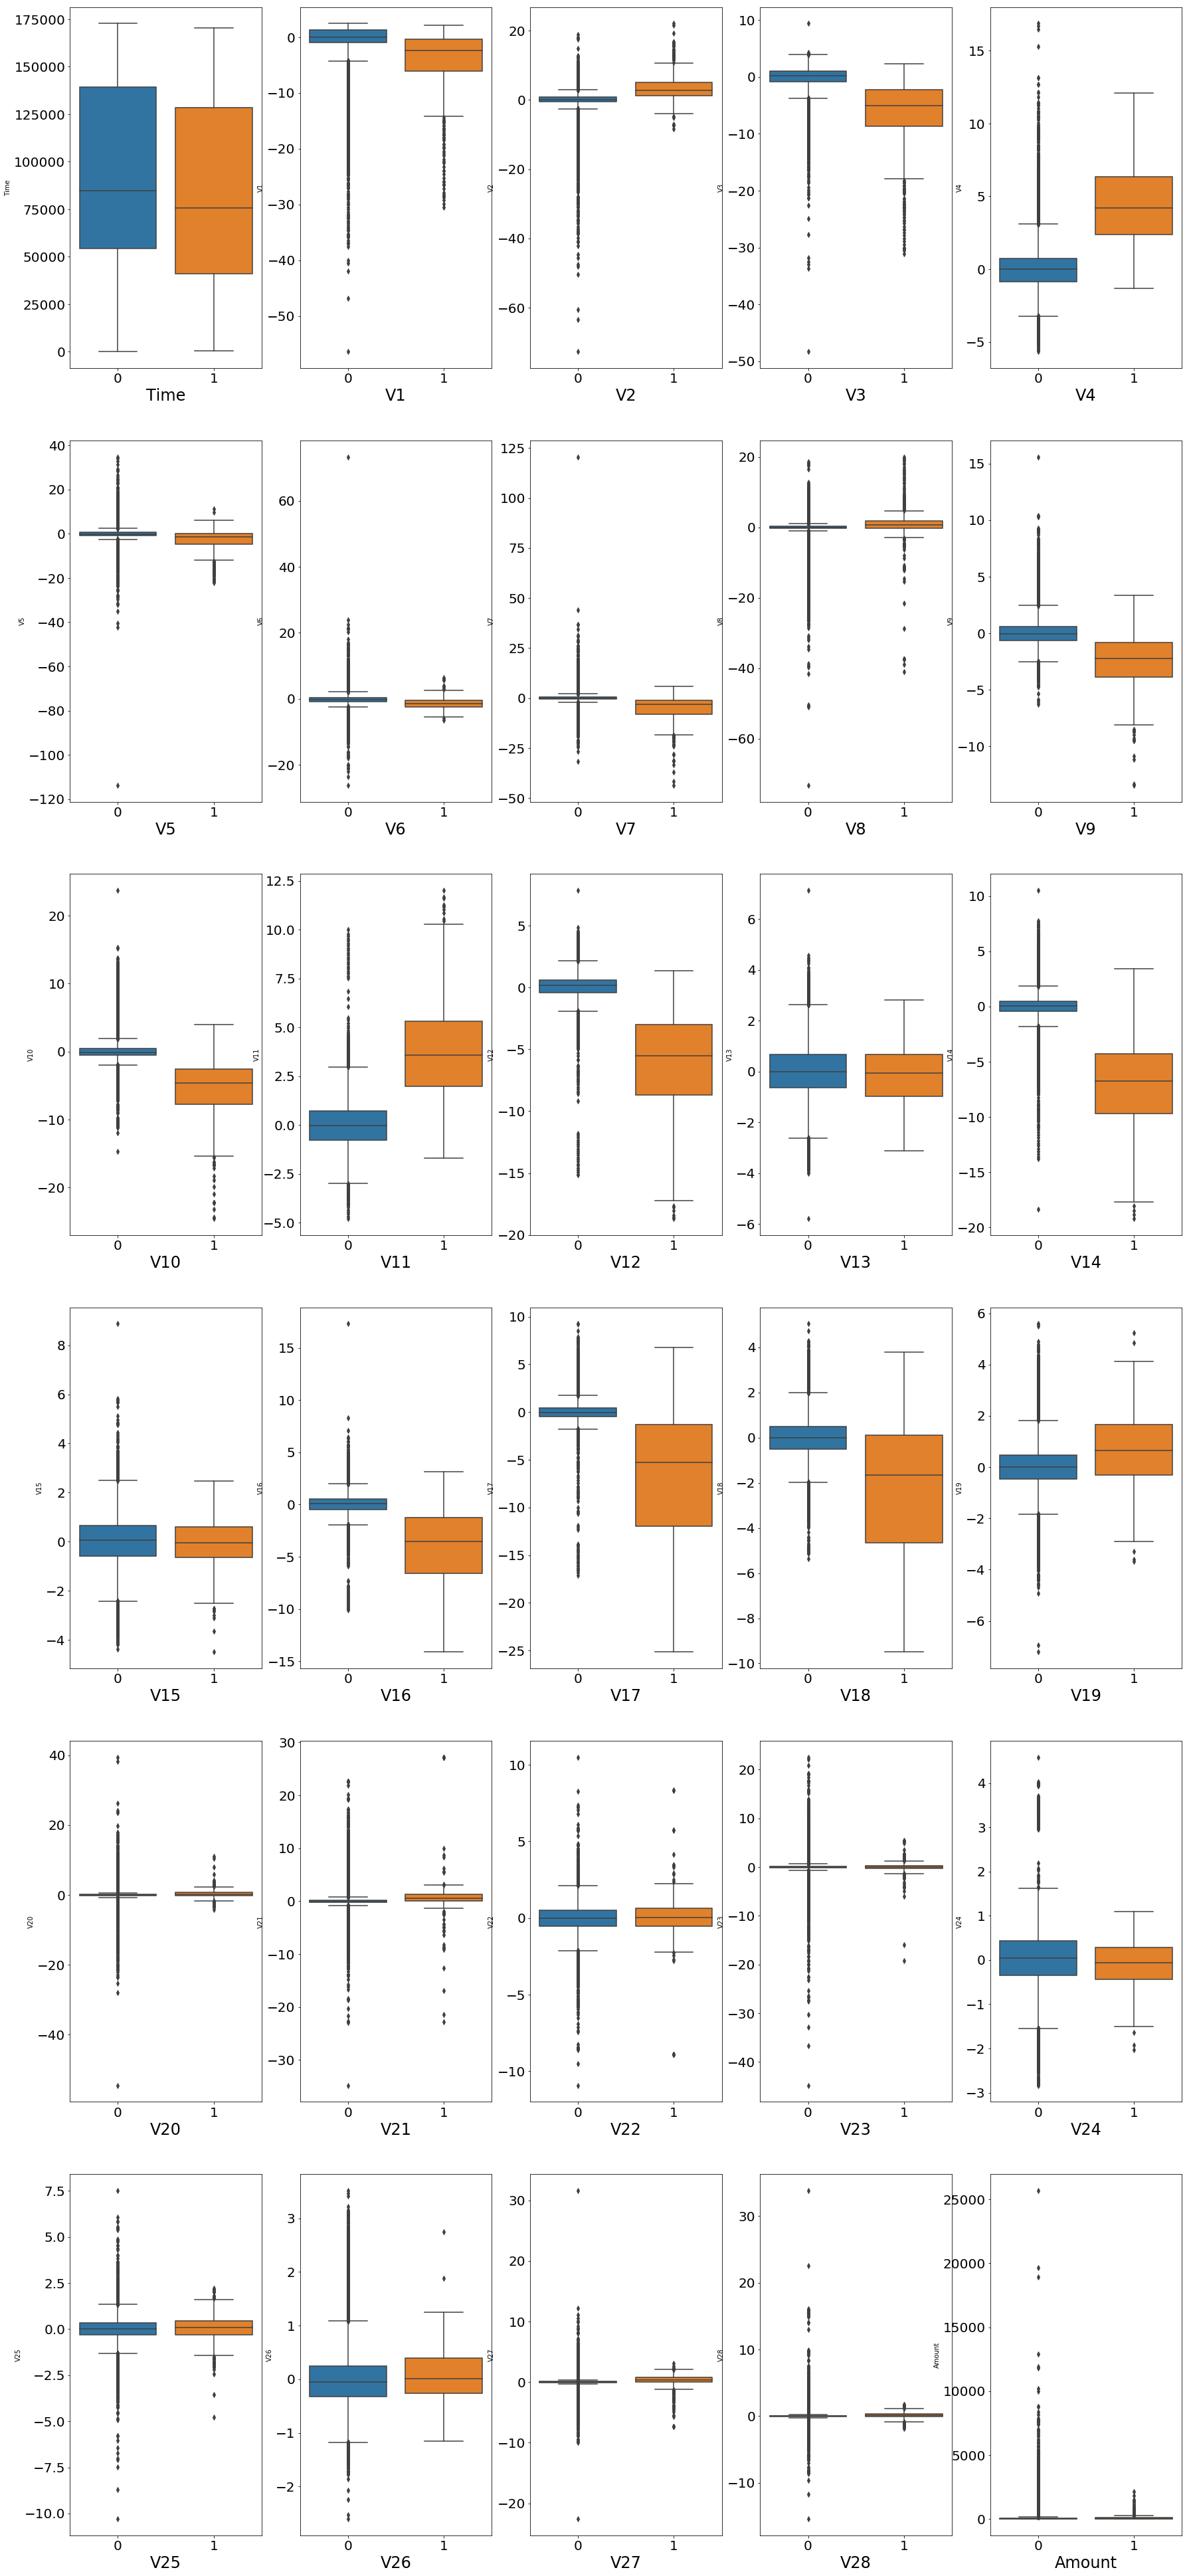

In [9]:
# Посмотрим распределение признаков на каждом классе - построим boxplot,
# видно, что на некторых признаках распределение сильно отличается в зависимости от класса, например, v3, v4, v16, v17,
# практически везде присутствуют выбросы
fig, axs = plt.subplots(6, 5, figsize=(30, 70))
j = 0
for i in df.drop(['Class'], axis=1).columns:
    ax = axs[j//5,j%5]
    ax= sns.boxplot(x=df['Class'], y=i, ax=ax, data=df.drop(['Class'], axis=1))
    ax.set_xlabel(i, size=24) 
    ax.tick_params(labelsize=20)
    j += 1

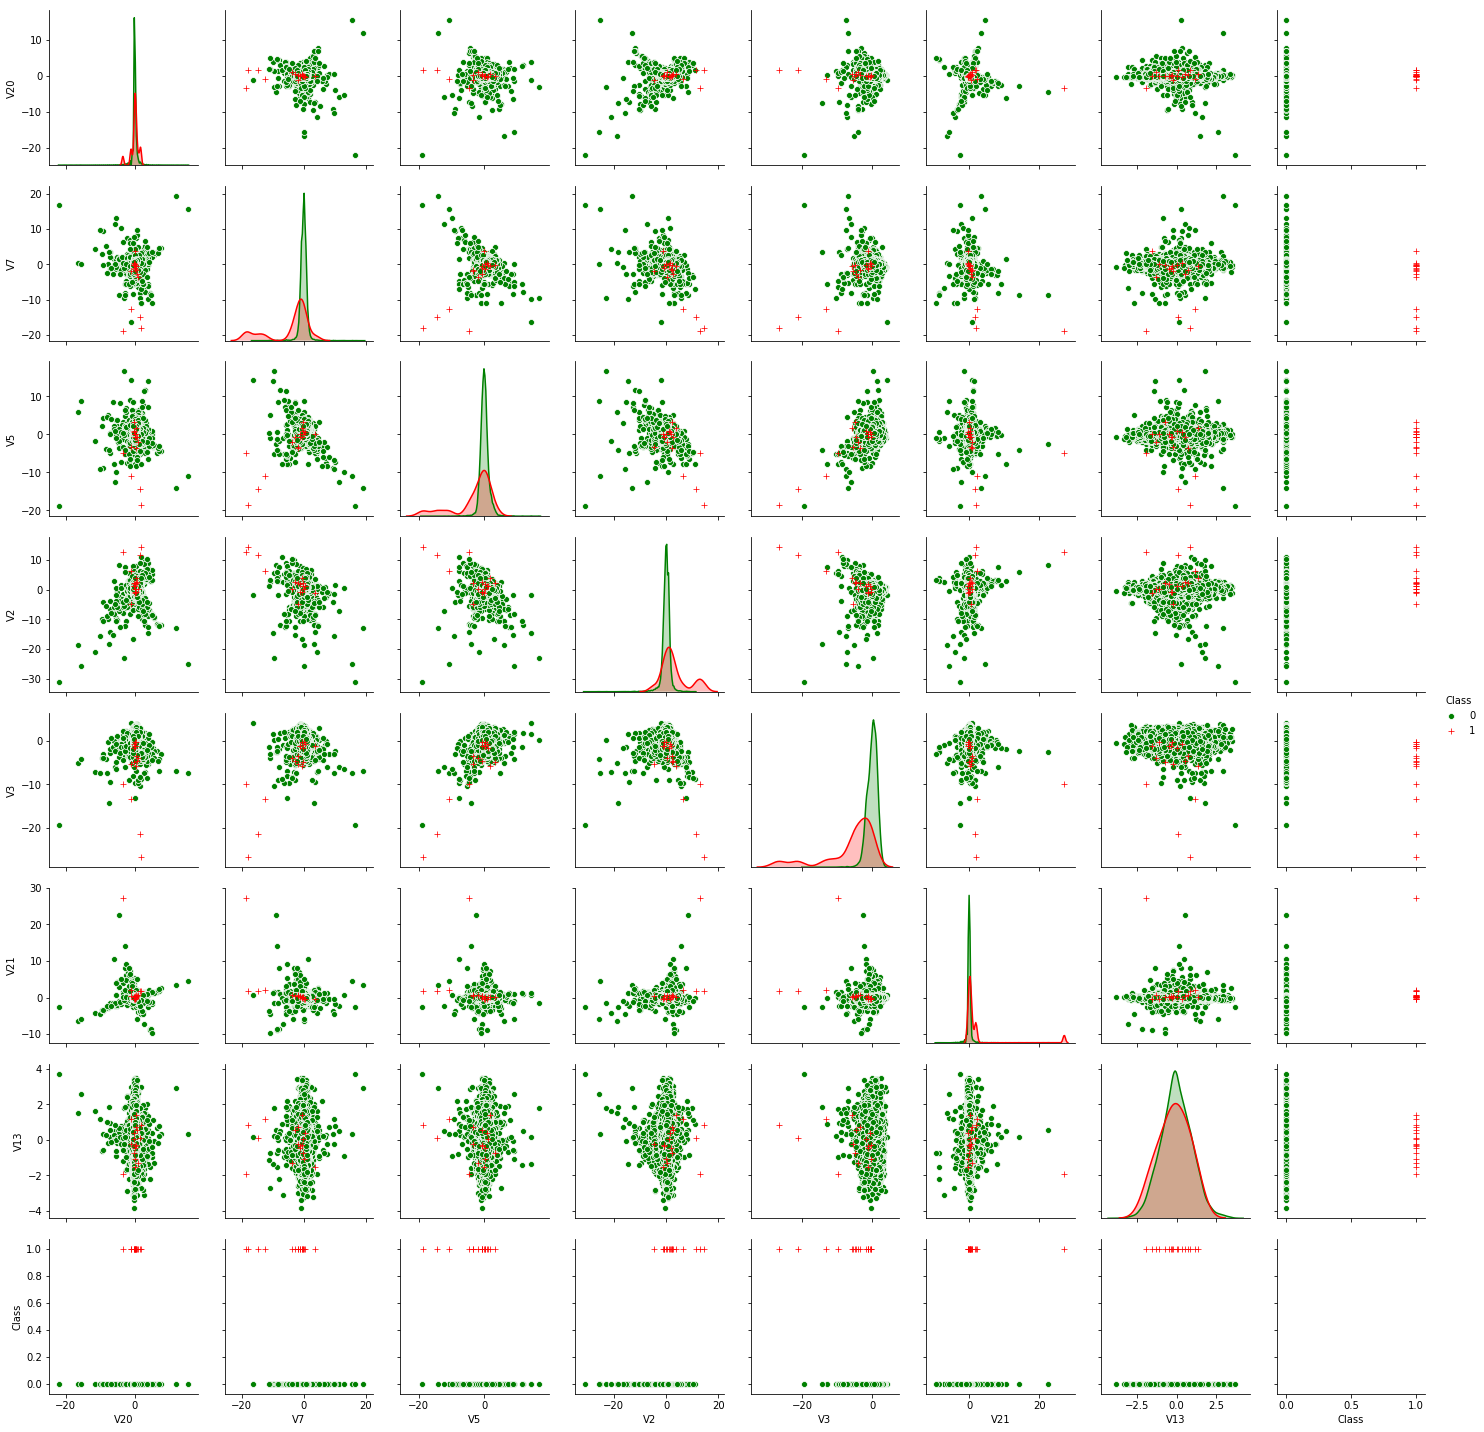

In [10]:
# Построим pairplot - попарное распределение признаков, 
# но сделаем это на случайной подвыборке, т.к. данных слишком много - будет неразборчиво.
# Видим, что часть выбросов является аномалиями, а часть нет, также часть аномалий не является выбросами по парам признаков,
# что говорит о том, что либо данные шумные, либо зависимость более сложная - 
# аномалии зависят от совокупности нескольких признаков одновременно, а не от пары
df_random = df.drop('Class', axis=1).sample(frac=0.03, random_state=10).sample(n=7, axis=1, random_state=10)
index_random = df_random.index
target_random = df[df.index.isin(index_random)][['Class']]
df_random = pd.concat([df_random, target_random], axis=1)
sns.pairplot(df_random, hue='Class', markers=["o", "+"], palette = {0:'g', 1:'r'})
plt.show()

In [11]:
# Создадим свой алгоритм, основанный на определении центра выборки, и в зависимости от удаленности от центра - 
# экстремальные значения будем считать аномалиями - это позволит использовать совокупность признаков всех одновременно, 
# а не каждый по отдельности.
# Параметры - доля выбросов [0;1] и метрика расстояния объектов друг от друга
class Distance(BaseEstimator):
    def __init__(self, ratio = 0.01, metric='euclidean'):
        self.ratio = 1 - ratio
        self.metric = metric
    def fit(self, X, y=None):
        self.center = np.mean(X, axis=0)
        self.center = self.center.reshape(1,self.center.shape[0])
        self.distance = cdist(self.center, X, metric=self.metric)
        self.threshold = np.quantile(self.distance, self.ratio)
    def predict(self, X, y=None):
        self.distance_test = cdist(self.center, X)
        self.total = np.where(self.distance_test <= self.threshold, 1, -1)[0]
        return self.total
    def fit_predict(self, X, y=None):
        self.fit(X, y=None)
        return self.predict(X, y=None)

In [12]:
# Класс препроцессинга - удаление целевой переменной
class Drop():
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        self.X = X
        self.X_drop = self.X.drop('Class', axis=1)
        return self.X_drop

In [13]:
drop = Drop()  # экземпляр удаления целевого признака
scaler = StandardScaler() # экземпляр нормализатора данных

# Создаем пайплайн препроцессинга
prep = Pipeline([
    ("drop", drop),
    ('scaler', scaler)
])

# размер получившейся таблицы
prep.fit_transform(df).shape

(284807, 30)

In [14]:
# добавляем в pipeline по умолчанию алгоритм изолирующего леса с параметром экспертной оценки доли аномалий
IF = IsolationForest(contamination=ratio)
pipe = Pipeline([
    ("preprocessing", prep),
    ("modelling", IF)
])
# посмотрим какие параметры есть у pipeline
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'modelling', 'preprocessing__memory', 'preprocessing__steps', 'preprocessing__verbose', 'preprocessing__drop', 'preprocessing__scaler', 'preprocessing__scaler__copy', 'preprocessing__scaler__with_mean', 'preprocessing__scaler__with_std', 'modelling__behaviour', 'modelling__bootstrap', 'modelling__contamination', 'modelling__max_features', 'modelling__max_samples', 'modelling__n_estimators', 'modelling__n_jobs', 'modelling__random_state', 'modelling__verbose', 'modelling__warm_start'])

In [15]:
# Так же заранее создадим функцию построения pairplot на случайной подвыборке на метках полученных моделями 
def pairplot(y_pred):
    df_ = pd.concat([df, pd.DataFrame(y_pred, columns = ['pred'])], axis=1)
    df_random = df_.drop(['Class','pred'], axis=1).sample(frac=0.03, random_state=10).sample(n=5, axis=1, random_state=10)
    index_random = df_random.index
    target_random = df_[df_.index.isin(index_random)][['pred']]
    df_random = pd.concat([df_random, target_random], axis=1)
    sns.pairplot(df_random, hue='pred', markers=["o", "+"], palette = {1:'g', -1:'r'})
    plt.show()

In [16]:
# Создадим целевую переменную со значенями 1 - не аномалия, -1 - аномалия, на которой будем проверять модели
target = df.Class.replace([0,1], [1,-1])

## Теперь посмотрим как работают разные алгоритмы, и затем проверим на истинной метке качество работы каждого

### IsolationForest:

In [17]:
%%time
# Обучим и получим метки класса изолирующего леса
y_pred_if = pipe.fit_predict(df)

Wall time: 36.5 s


In [18]:
# Посмотрим качество по основным метрикам - 27% полнота и 27% точность срабатывания,
# Возможно, качество не очень, но все же треть аномалий находит, при условии, что это обучение без учителя может и не плохо
print(classification_report(target, y_pred_if))

              precision    recall  f1-score   support

          -1       0.27      0.27      0.27       492
           1       1.00      1.00      1.00    284315

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807



In [19]:
#  По матрице неточностей видно, что 132 выброса опеределны верно, и по 360 FP и FN
print(confusion_matrix(target, y_pred_if))

[[   132    360]
 [   360 283955]]


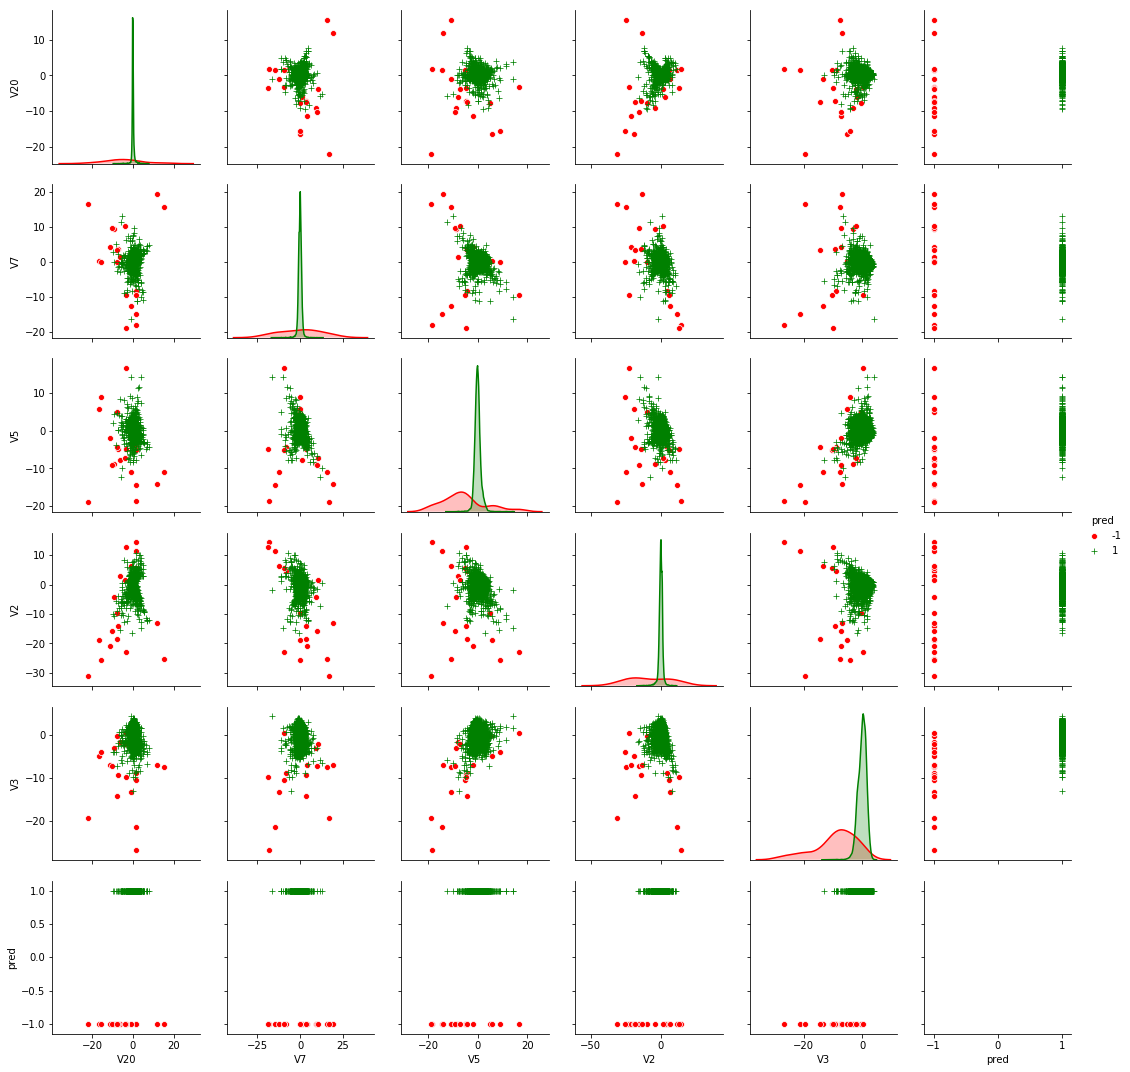

In [20]:
# Посмотрим на pairplot по полученным меткам изолирующего леса, также на случайной подвыборке,
# Видно, что случайный лес хорошо отделил выбросы
pairplot(y_pred_if)

### OneClassSVM:

In [21]:
%%time
# Теперь в пайплайн добавим OneClassSVM и обучим модель
pipe.set_params(modelling=OneClassSVM(nu=ratio))
y_pred_ocs = pipe.fit_predict(df)

Wall time: 3min 31s


In [22]:
# Качетсво работы хуже изолирующего леса по точности срабатывания и f1
print(classification_report(target, y_pred_ocs))

              precision    recall  f1-score   support

          -1       0.09      0.28      0.14       492
           1       1.00      1.00      1.00    284315

    accuracy                           0.99    284807
   macro avg       0.55      0.64      0.57    284807
weighted avg       1.00      0.99      1.00    284807



In [23]:
# 138 аномалий верно найдено, 354 не определены, 1345 определены не верно как аномалии
confusion_matrix(target, y_pred_ocs)

array([[   138,    354],
       [  1345, 282970]], dtype=int64)

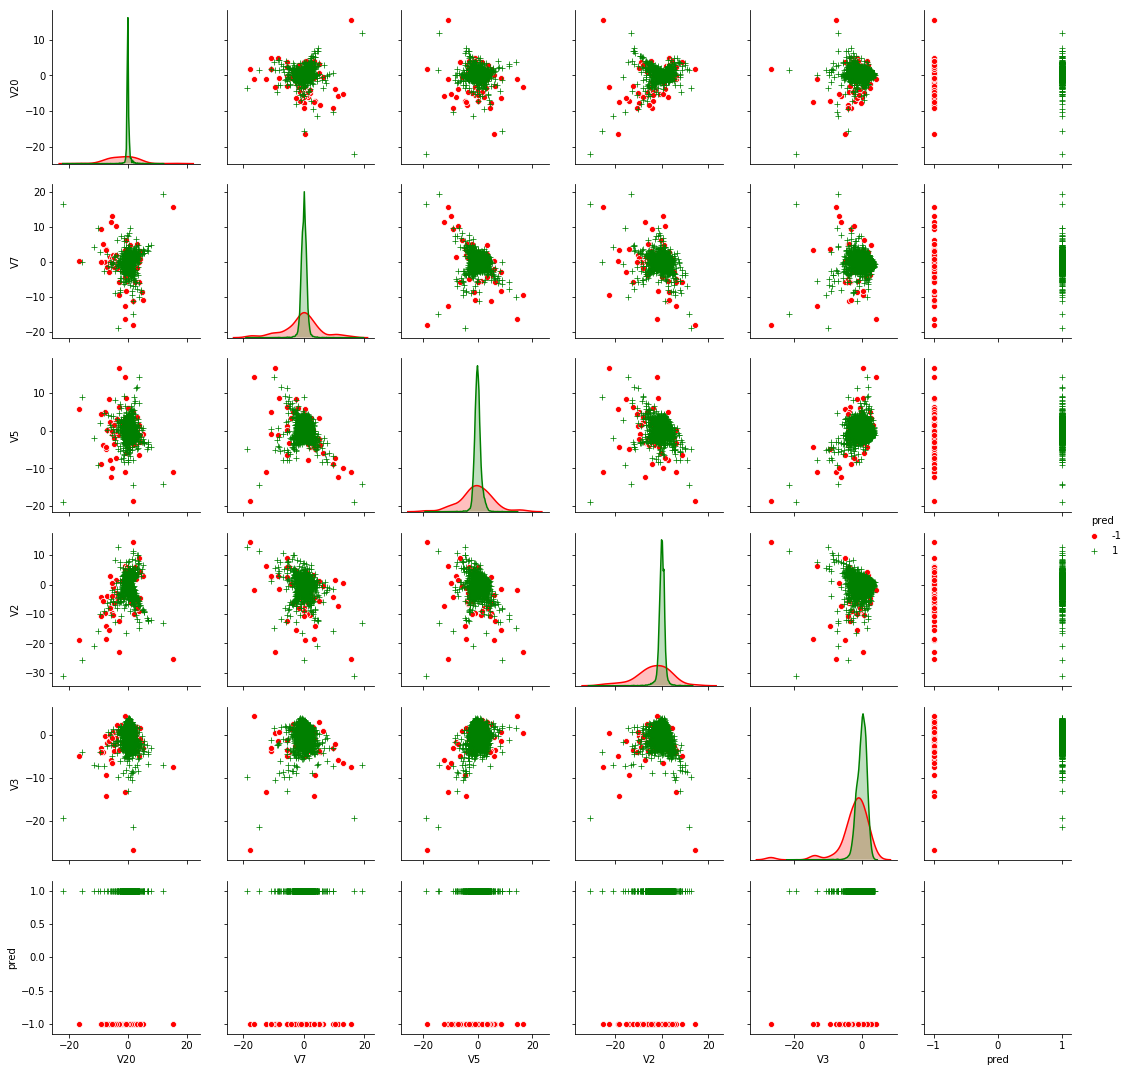

In [24]:
# На pairplot видно так же, что не все выбросы были определены как аномалии, 
# хотя надо понимать, что зависимости могут быть более сложные, зависеть могут от большего числа признаков, а не просто от двух
pairplot(y_pred_ocs)

### Distanсe base:

###### euclidean

In [25]:
%%time
# Обучим базовый алгоритм на евлидовой метрике
dist = Distance(ratio=ratio)
pipe.set_params(modelling=dist)
y_pred_dist_e = pipe.fit_predict(df)

Wall time: 432 ms


In [26]:
# Обучается очень быстро, качество лучше, чем OneClassSVM, и похуже изолирующего леса
print(classification_report(target, y_pred_dist_e))

              precision    recall  f1-score   support

          -1       0.23      0.23      0.23       492
           1       1.00      1.00      1.00    284315

    accuracy                           1.00    284807
   macro avg       0.62      0.62      0.62    284807
weighted avg       1.00      1.00      1.00    284807



In [27]:
# 114 выбросов верно определены, 378 определены не верно и столько же не определено
print(confusion_matrix(target, y_pred_dist_e))

[[   114    378]
 [   378 283937]]


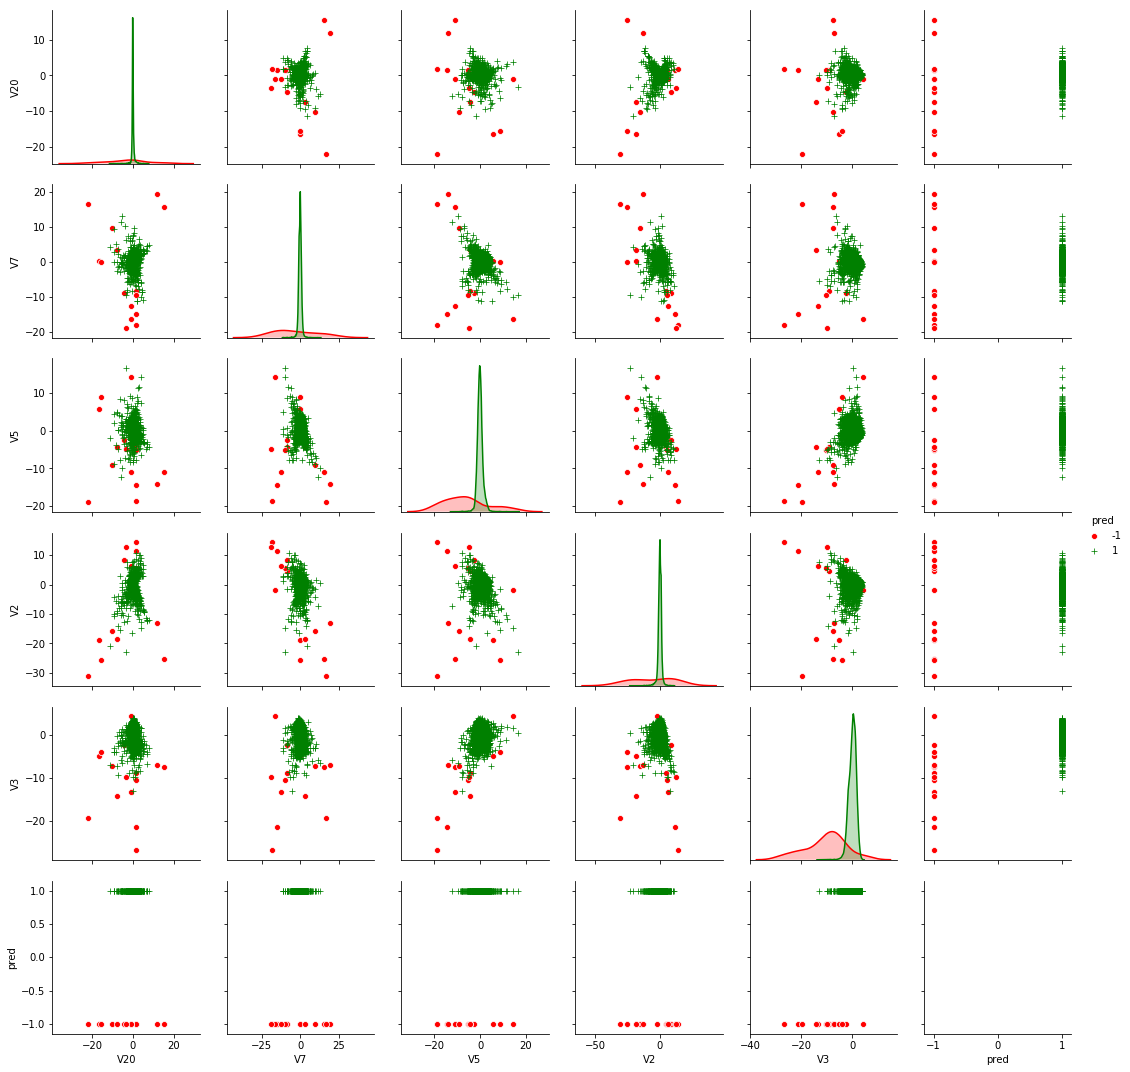

In [28]:
# Ожидаемо почти все выбросы попали в аномалии
pairplot(y_pred_dist_e)

###### chebyshev

In [29]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'modelling', 'preprocessing__memory', 'preprocessing__steps', 'preprocessing__verbose', 'preprocessing__drop', 'preprocessing__scaler', 'preprocessing__scaler__copy', 'preprocessing__scaler__with_mean', 'preprocessing__scaler__with_std', 'modelling__metric', 'modelling__ratio'])

In [30]:
%%time
# Теперь посмотрим как работает этот же алгоритм, но на метрике Чебышева
pipe.set_params(modelling__metric='chebyshev')
y_pred_dist_cheb = pipe.fit_predict(df)

Wall time: 438 ms


In [31]:
# Тут упала точность срабатывания, но зато хорошо выросла полнота
print(classification_report(target, y_pred_dist_cheb))

              precision    recall  f1-score   support

          -1       0.13      0.46      0.20       492
           1       1.00      0.99      1.00    284315

    accuracy                           0.99    284807
   macro avg       0.56      0.73      0.60    284807
weighted avg       1.00      0.99      1.00    284807



In [32]:
# 226 аномалий определено, 266 не определено, 1502 определены не верно
print(confusion_matrix(target, y_pred_dist_cheb))

[[   226    266]
 [  1502 282813]]


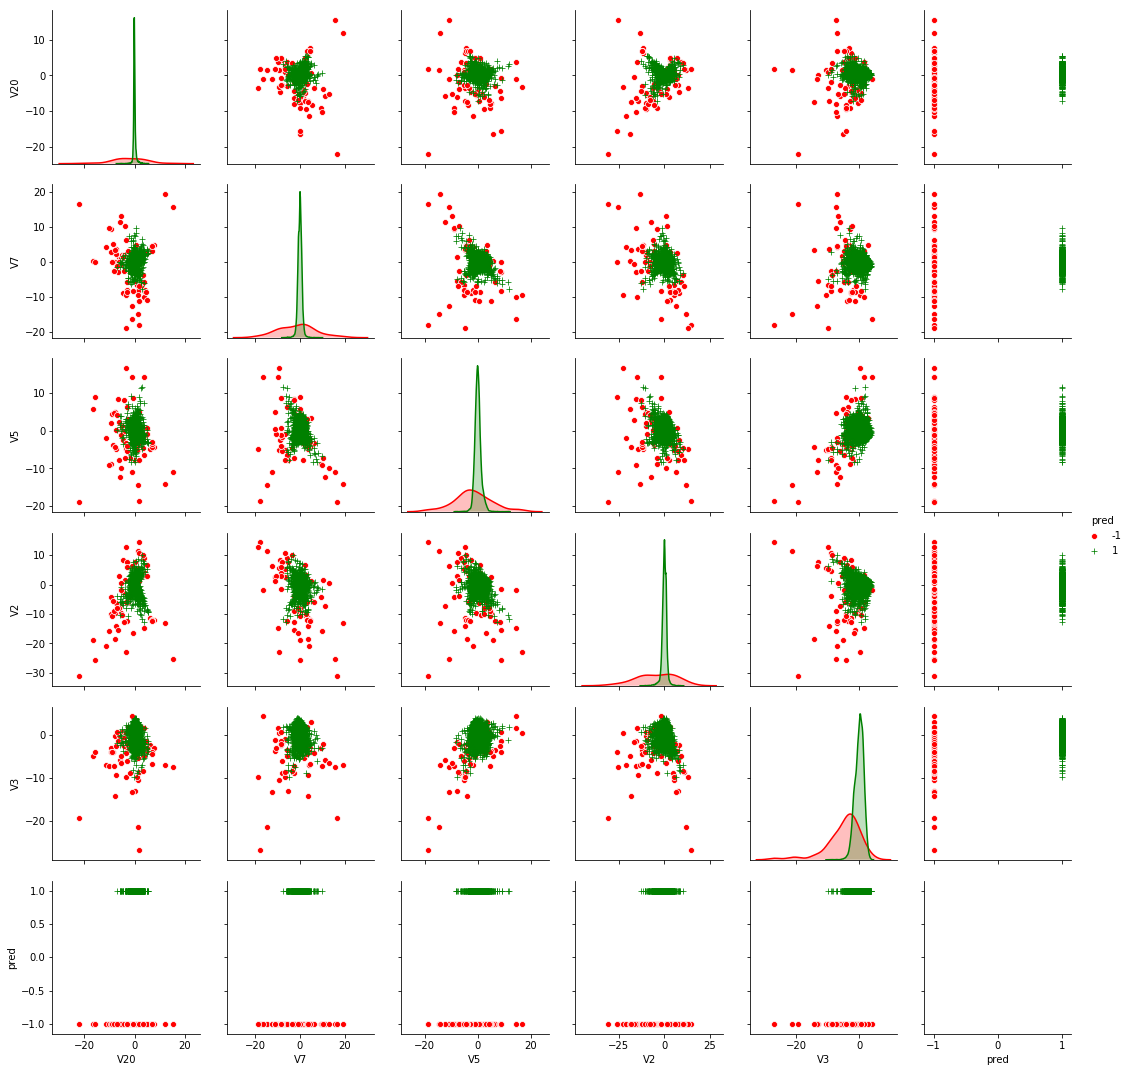

In [33]:
# Здесь видно, что алгоритм сработал более агрессивно и выявил больше аномалий, чем на Евклидовом расстоянии
pairplot(y_pred_dist_cheb)

### DBSCAN:

In [34]:
%%time
# Теперь применим к выборке алгоритм кластеризации - DBSCAN
DB = DBSCAN(eps=0.5, n_jobs=-1)
pipe.set_params(modelling=DB)
pipe.fit(df)

Wall time: 2min 27s


In [35]:
y_pred_dbscan_05 = pipe['modelling'].labels_
y_pred_dbscan_05 = np.where(y_pred_dbscan_05 ==-1, -1, 1)

In [36]:
# На базовых настройках качество очень плохое, хотя и нашел почти все выбросы, но точность срабатывания билзка у нулю
print(classification_report(target, y_pred_dbscan_05))

              precision    recall  f1-score   support

          -1       0.00      0.98      0.00       492
           1       1.00      0.23      0.38    284315

    accuracy                           0.24    284807
   macro avg       0.50      0.61      0.19    284807
weighted avg       1.00      0.24      0.38    284807



In [37]:
# 483 выброса найдены, не найдено лишь 9, но при этом 3/4 выборки поместил в выбросы
confusion_matrix(target, y_pred_dbscan_05)

array([[   483,      9],
       [217579,  66736]], dtype=int64)

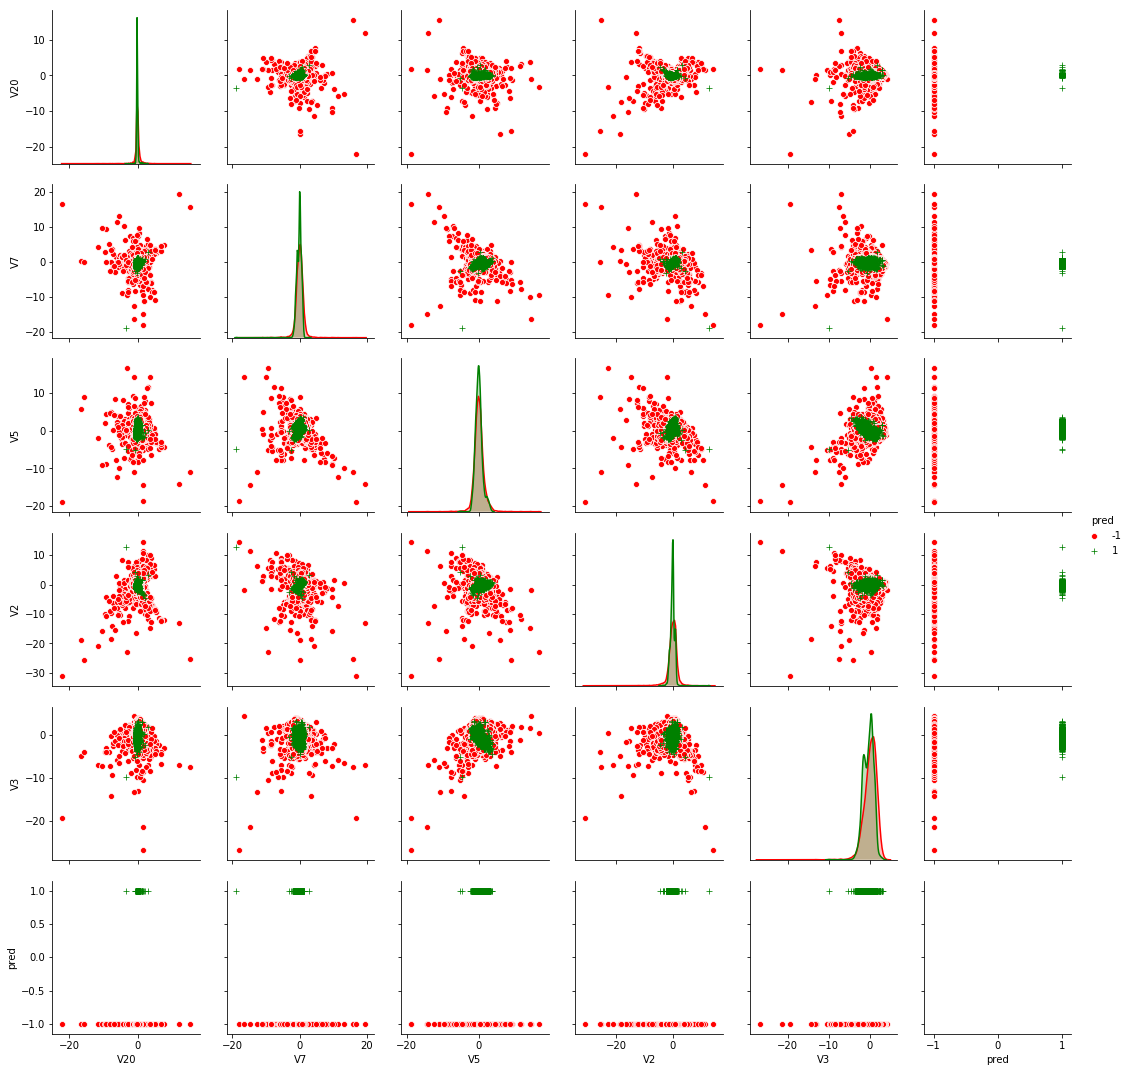

In [38]:
# На pairplot видно, что больая часть выборки окрашена красным - аномалии, что, конечно, говорит о плохом качестве
pairplot(y_pred_dbscan_05)

In [39]:
%%time
# Увеличим параметр eps для уменьшения доли выбросов (как это было показано в предыдущем ДЗ, 
# увеличение eps ведет к уменьшению доли аномалий)
DB = DBSCAN(eps=1.5, n_jobs=-1)
pipe.set_params(modelling=DB)
pipe.fit(df)

Wall time: 20min 35s


In [40]:
y_pred_dbscan15 = pipe['modelling'].labels_
y_pred_dbscan15 = np.where(y_pred_dbscan15 ==-1, -1, 1)

In [41]:
# По метрикам видно, что качество по прежнему очень плохое
print(classification_report(target, y_pred_dbscan15))

              precision    recall  f1-score   support

          -1       0.00      0.95      0.01       492
           1       1.00      0.66      0.79    284315

    accuracy                           0.66    284807
   macro avg       0.50      0.80      0.40    284807
weighted avg       1.00      0.66      0.79    284807



In [42]:
# По матрице неточностей всё же видно, что качество выросло, 
# уже только треть принята за аномалии, а не 3/4, но еще далеко до удовлетворительного
confusion_matrix(target, y_pred_dbscan15)

array([[   467,     25],
       [ 97717, 186598]], dtype=int64)

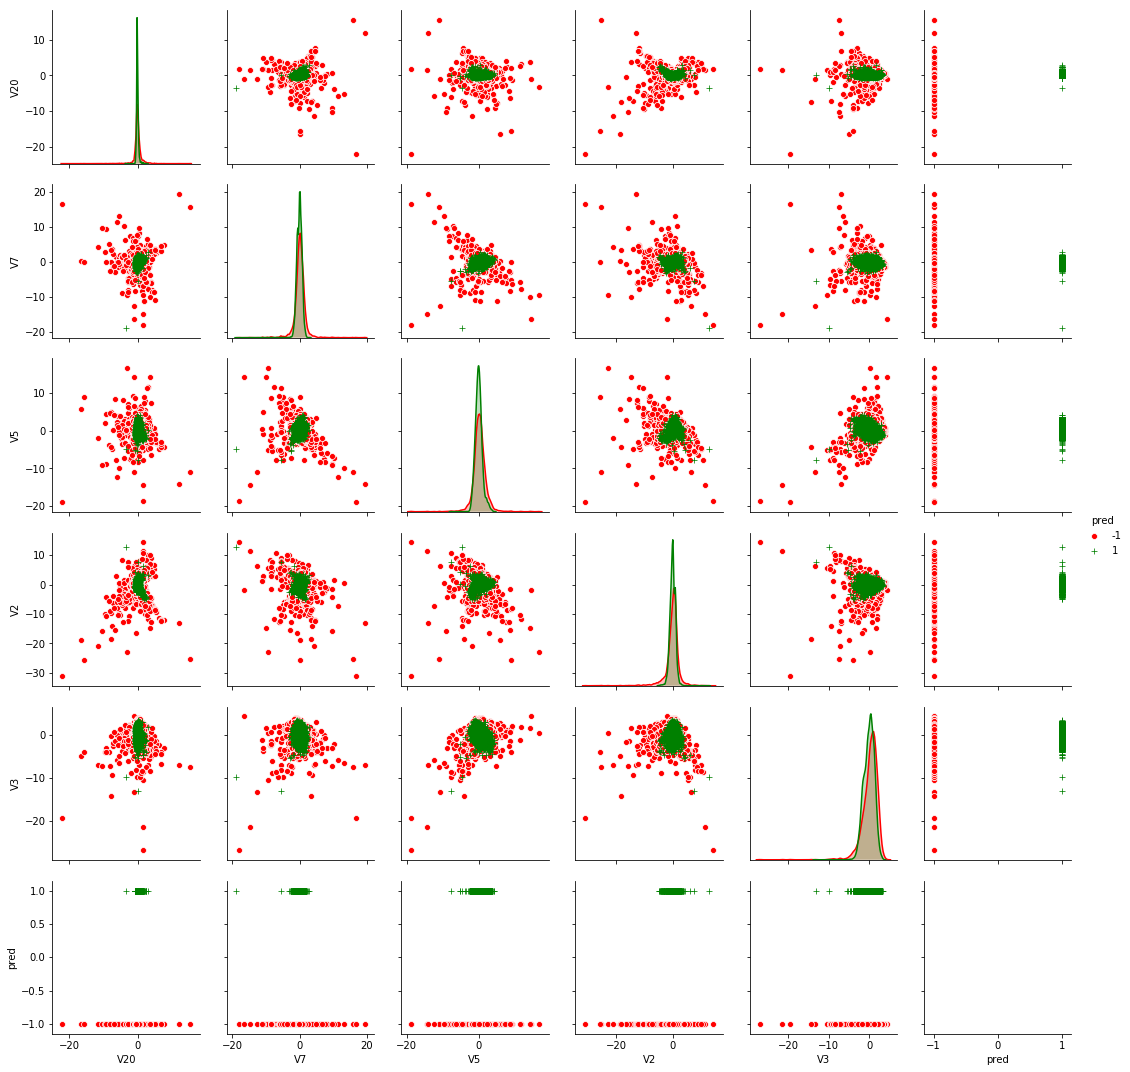

In [43]:
# По сравнению с предыдщем графиком чуть больше стало основных зелёных меток
pairplot(y_pred_dbscan15)

In [44]:
%%time
# Еще больше увеличим eps и уменьшим минимальное число точек
DB = DBSCAN(eps=3, min_samples=4, n_jobs=-1)
pipe.set_params(modelling=DB)
pipe.fit(df)

Wall time: 48min 32s


In [45]:
# На этих параметрах качество улучшилось, но точность срабатывания всё еще не удовлетворительная
y_pred_dbscan3 = pipe['modelling'].labels_
y_pred_dbscan3 = np.where(y_pred_dbscan3 ==-1, -1, 1)
print(classification_report(target, y_pred_dbscan3))

              precision    recall  f1-score   support

          -1       0.02      0.68      0.04       492
           1       1.00      0.94      0.97    284315

    accuracy                           0.94    284807
   macro avg       0.51      0.81      0.51    284807
weighted avg       1.00      0.94      0.97    284807



In [46]:
# Очень много ложных срабатываний 16115
confusion_matrix(target, y_pred_dbscan3)

array([[   336,    156],
       [ 16115, 268200]], dtype=int64)

###### Из качества работы алгоритмов без учителя видно, что зависимости сложные в датасете, поэтому посмотрим как бы отработал граидентый бустинг, т.к. метки данных есть всё же. Сделаем это на LGBMClassifier - как на быстром и качественном алгоритме

In [47]:
%%time
# Посмотрим на кроссвалидации качество на метрике f1, поменяем в пайпайне алгоритм
# Скорость работы очень высокая
LGBM = LGBMClassifier(class_weight='balanced')
pipe.set_params(modelling=LGBM)
score = cross_validate(pipe, df, df['Class'], cv=5, scoring='f1')
score

Wall time: 13.5 s


In [48]:
# Качетсво в два раза выше самого лучшего до этого - изолирующего леса, но всё же совсем не близко к 1.0, 
# скорее всего датасет шумный
score['test_score'].mean()

0.6666706918444752

## UMAP

In [49]:
%%time
# Теперь с помощью алгоритма umap (сокращение пространства признаков), визуализируем метки изолирующего леса
# Установим umap в пайплайн и обучим модель
um = umap.UMAP()
pipe.set_params(modelling=um)
u = pipe.fit_transform(df)

Wall time: 9min 49s


In [50]:
# Добавим к полученной матрице сокращенного пространства все предсказанные метки предыдущих моделей (DBSCAN последний лучший вариант)
u_all = np.concatenate((u, y_pred_if.reshape(y_pred_if.shape[0],1), y_pred_ocs.reshape(y_pred_ocs.shape[0],1), 
    y_pred_dist_e.reshape(y_pred_dist_e.shape[0],1), y_pred_dist_cheb.reshape(y_pred_dist_cheb.shape[0],1),
                      y_pred_dbscan3.reshape(y_pred_dbscan3.shape[0],1) ), axis=1)

In [51]:
# Выберем случайную подвыборку, т.к слишком много объектов, весь график сольется
idx = np.random.randint(u_all.shape[0], size=20000)
u_all = u_all[idx,:]

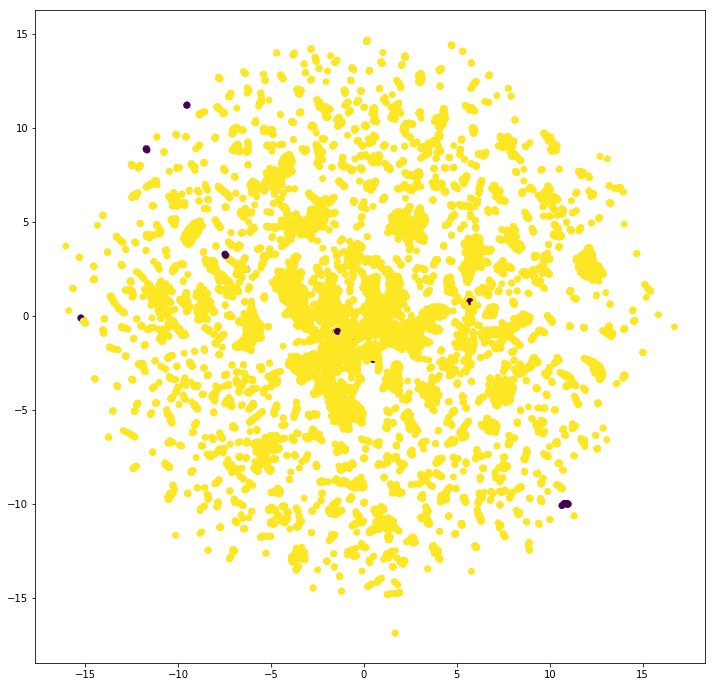

In [52]:
# Изолирующий лес
plt.figure(figsize=(12, 12))
plt.scatter(u_all[:,0], u_all[:,1], c=u_all[:,2])
plt.show()
# Выбросов мало в связи с их малой долей, не определить насколько хорошо они располагаются на графике

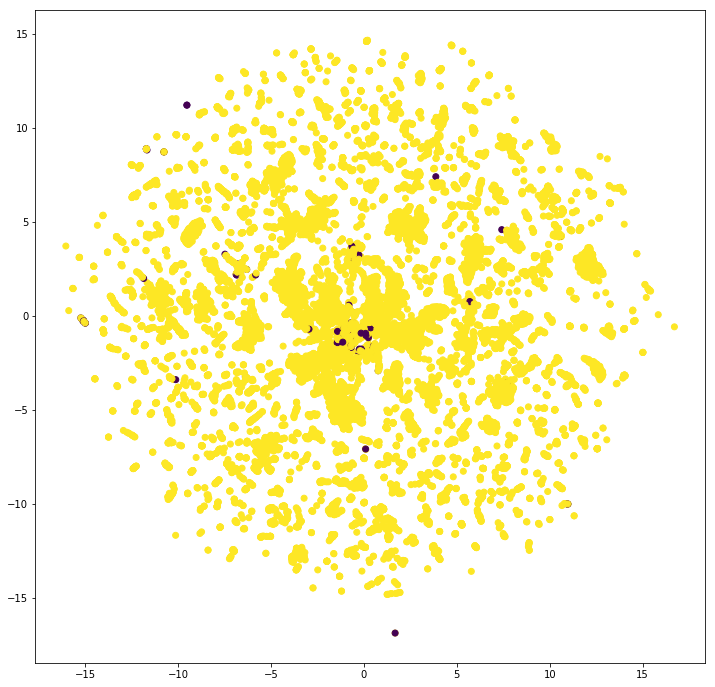

In [53]:
# OneClassSVM
plt.figure(figsize=(12, 12))
plt.scatter(u_all[:,0], u_all[:,1], c=u_all[:,3])
plt.show()
# Тут что-то по краям, что-то в центре

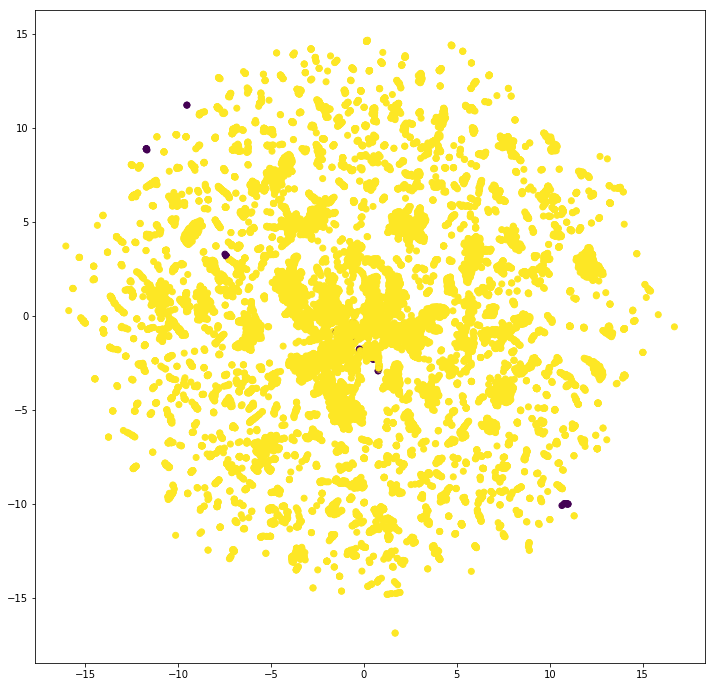

In [54]:
# Базовый дистанционный алгоритм на основе Евклидова расстояния 
plt.figure(figsize=(12, 12))
plt.scatter(u_all[:,0], u_all[:,1], c=u_all[:,4])
plt.show()

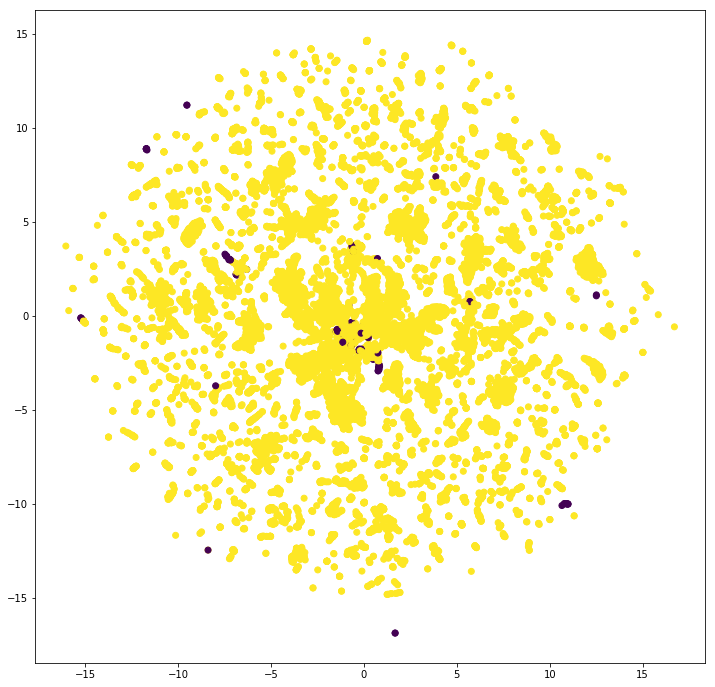

In [55]:
# Базовый дистанционный алгоритм на основое расстояния Чебышева
plt.figure(figsize=(12, 12))
plt.scatter(u_all[:,0], u_all[:,1], c=u_all[:,5])
plt.show()
# Тут сразу в глаза бросается большее число найденных выбросов, поскольку полнота выше, чем в случае Евклидова расстояния,
# И в целом выбросы находятся по краям сгустков насколько об этом можно судить

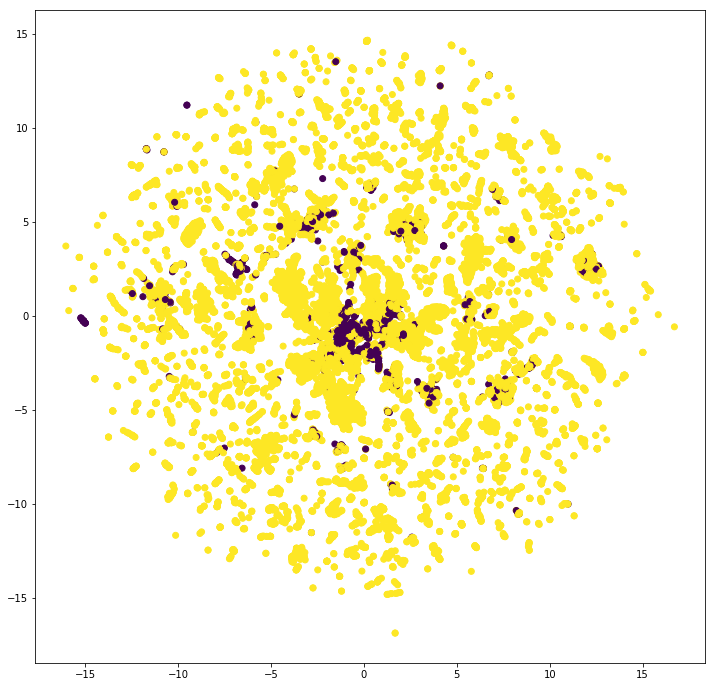

In [56]:
# DBSCAN с лучшим результатом
plt.figure(figsize=(12, 12))
plt.scatter(u_all[:,0], u_all[:,1], c=u_all[:,6])
plt.show()
# Сразу видно что число предсказанных аномалий занимает значительную площадь,
# превышает экспертную оценку по доле процентов - качество плохое

## Выводы:

- Лучше всех отработал изолирующий лес f1=0.27, что, думаю, не так плохо, т.к. зависимости довольно сложные и/или много шума в данных. Судя по первому графику pairplot - много аномалий расположено в центре, а не только по краям сгустков точек;
- На удивление не сильно хуже себя показал по качеству работы на данном датасете написаный руками алгоритм основанный на расстоянии f1=0.23. Кроме того на метрике расстояния Чебышева можно резко увеличить полноту до recall=0.46. Если в задаче важнее будет находить по максимуму весь фрод, поступившись точностью срабатывания при этом, то это хороший вариант, т.к больше нигде такой высокой полноты не было (DBSCAN в расчёт не берём, он отработал не удовлетворительно);
- Далее по качеству идёт OneClassSVM (f1=0.14);
- Плохое качество показал DBSCAN - полнота хоть и близка к 1, но точность срабатывания стремится к нулю, алгоритм большую часть выборки определяет как аномалии. Кроме того скорость обучения у него низкая, что затрудняет подбор параметров. Если выкручивать параметры eps по максимуму и min_samples по минимуму, чтобы добиться приемлемого качества, происходит ошибка переполнения оперативной памяти;
- Также из-за большой выборки (>280 тыс. объектов) и низкого процента фрода увидеть качество работы алгоритмов на UMAP не особо получается, поэтому лучше смотреть на pairplot на подвыборках - там более отчетливо видно как алгоритмы определяют аномалии;
- Не очень высокое качество работы моделей без учителя может быть еще обусловено шумными данными, бустинг LGBMClassifier показал качество тоже далекое до 100% f1=0.66.